In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
sns.set(style="whitegrid")

In [23]:
df = pd.read_csv('Data/test_st.csv')

In [24]:
df['value_created_at'] = pd.to_datetime(df['value_created_at'])

In [25]:
df_train = df[:2500]
df_test = df[2500:]

In [28]:
df_train = df_train[df_train.NGA > .2]

In [29]:
list_sensors = ['NGA']
list_metrics = ['Median', 'STD', 'PPV','rms','ppv','cf','mf','sf','if']
window_size = 100
num_window = int(len(df_train)//window_size)
cut_factor = .2

In [30]:
def calc_metric_stats(serie, metric):
    if metric == 'STD':
        return np.std(serie)
    elif metric == 'PPV':
        return np.max(serie) - np.min(serie)
    elif metric == 'Median':
        return np.median(serie)
    elif metric == 'z_score' :
        mean_value = serie.mean()
        std_value = serie.std()
        return (serie - mean_value) / std_value
    elif metric == 'rms':
        return np.sqrt(np.mean(np.square(serie)))
    elif metric == 'ppv':
        ppv = np.max(serie) - np.min(serie)
        return ppv
    elif metric == 'cf':
        max_value = np.max(np.abs(serie))
        sum_values = np.sum(np.square(serie))
        return max_value / np.sqrt(sum_values)
    elif metric == 'mf':
        mu = np.mean(serie)
        max_value = np.max(serie)
        min_value = np.min(serie)
        return (max_value - min_value) / mu
    elif metric == 'sf':
        mu = np.mean(serie)
        sigma = np.std(serie)
        return sigma / mu
    elif metric == 'if':
        max_value = np.max(np.abs(serie))
        sum_values = np.sum(np.abs(serie))
        return max_value / sum_values


In [31]:
def Algorithm2(F, J, K, cut_factor, data_full):
    list_idx_cut = list()
    cut = int(np.round(cut_factor * K))
    if(cut > 0):
        D = F*J
        lpoints = list()
        for k in range(K):
            point = np.zeros(D)
            d = 0
            for i in range(F):
                for j in range(J):
                    point[d] = data_full[k][i][j]
                    d += 1
            lpoints.append(point)
            
        maxpoint = np.full(D, -np.inf)
        minpoint = np.full(D, np.inf)

        for k in range(K):
            for d in range(D):
                maxpoint[d] = max(lpoints[k][d], maxpoint[d])
                minpoint[d] = min(lpoints[k][d], minpoint[d])

        lpoints_normalized = list()
        for k in range(K):
            point = np.zeros(D)
            for d in range(D):
                point[d] = (lpoints[k][d] - minpoint[d])/(maxpoint[d] - minpoint[d])
            lpoints_normalized.append(point)

        centroid = np.zeros(D)
        for k in range(K):
            for d in range(D):
                centroid[d] += lpoints_normalized[k][d]/K

        list_dist_centroid = list()
        for k in range(K):
            list_dist_centroid.append(np.linalg.norm(lpoints_normalized[k]-centroid))

        order = np.argsort(list_dist_centroid)
        for c in range(cut):
            list_idx_cut.append(order[len(order)-c-1])
    return list_idx_cut

In [32]:
def create_dataframe(data_range, list_sensors, list_metrics):
    temp = {"min" : {} , "max" : {}}
    for idx_sensor in range(len(list_sensors)) :
        for metric in list_metrics : 
            temp["min"][(list_sensors[idx_sensor], metric)] = data_range[idx_sensor][0][list_metrics.index(metric)]
            temp["max"][(list_sensors[idx_sensor], metric)] = data_range[idx_sensor][1][list_metrics.index(metric)]
    # print(temp)
    return pd.DataFrame(temp)

In [33]:
F = len(list_sensors)
J = len(list_metrics)
K = num_window
N = window_size
data_full = np.zeros((K,F,J))

In [34]:
for k in range(K):
    for i in range(F):
        data_sensor = df_train[list_sensors[i]].values
        serie = data_sensor[k*N:(k+1)*N]
        for j in range(J):
            # print(list_metrics[j])
            data_full[k][i][j] = calc_metric_stats(serie, list_metrics[j])
            #print(data_full)

In [35]:
data_full.shape

(24, 1, 9)

In [36]:
list_idx_cut = Algorithm2(F, J, K, cut_factor, data_full)

In [37]:
list_idx_cut

[22, 21, 3, 12, 23]

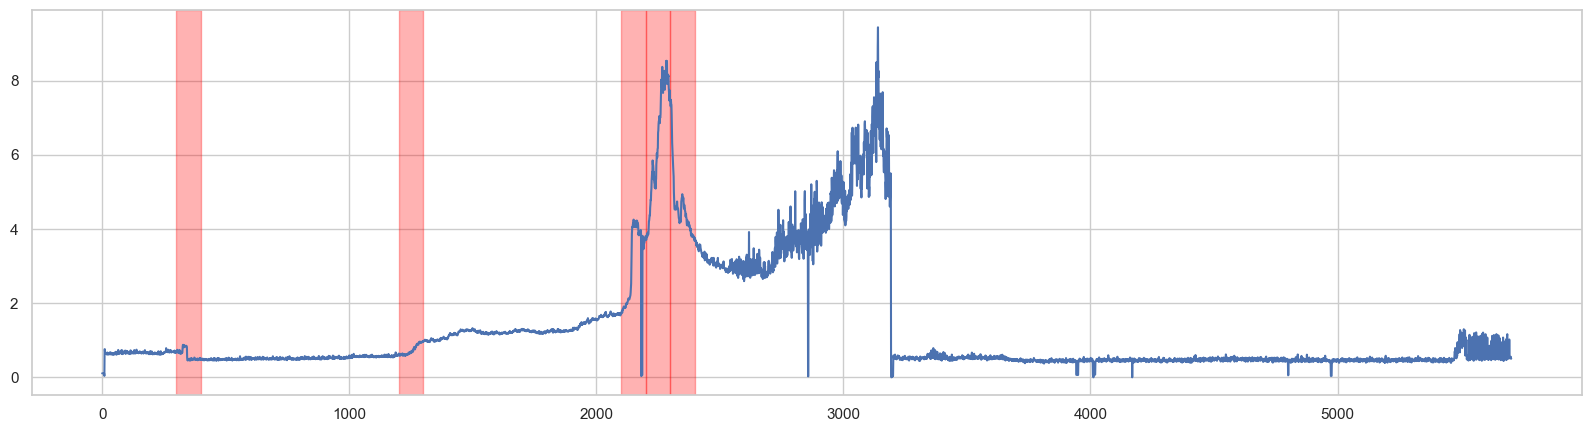

In [38]:
data_length = len(df_train.NGA.values)
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(df.NGA.values)
for idx in list_idx_cut:
    start = idx * 100
    end = (idx + 1) * 100
    if start < data_length:
        end = min(end, data_length)  
        ax.axvspan(start, end, color='red', alpha=0.3)

In [39]:
data_range = list()
for i in range(F):
    lmtr_min = list()
    lmtr_max = list()
    for j in range(J):
        list_metric_per_window = list()
        for k in range(K):
            if(k not in list_idx_cut):
                list_metric_per_window.append(data_full[k][i][j])
        lmtr_min.append(np.min(list_metric_per_window))
        lmtr_max.append(np.max(list_metric_per_window))
    data_range.append((lmtr_min, lmtr_max))

In [40]:
# data_to_df = list()
# for j in range(J):
    
#     list_min_values_per_sensor = list()
#     for i in range(F):
#         list_min_values_per_sensor.append(data_range[i][0][j])
#     data_to_df.append(list_min_values_per_sensor)
    
#     list_max_values_per_sensor = list()
#     for i in range(F):
#         list_max_values_per_sensor.append(data_range[i][1][j])
#     data_to_df.append(list_max_values_per_sensor)

# data_to_df
df_model = create_dataframe(data_range, list_sensors, list_metrics)
df_model

min       max
NGA Median  0.480700  1.685870
    STD     0.016545  0.091695
    PPV     0.070010  0.313610
    rms     0.480336  1.690351
    ppv     0.070010  0.313610
    cf      0.105342  0.116606
    mf      0.102259  0.257417
    sf      0.018082  0.062527
    if      0.010537  0.011671

In [41]:
def test(list_sensors, list_metrics, current_window, df_model):
    F = len(list_sensors)
    J = len(list_metrics)
    # report = dict()
    # sum_error_rel = 0
    for name_sensor in list_sensors:
        # list_sensors_affecteds = list()
        serie = current_window[name_sensor].values
        for j in range(J):
            metric = calc_metric_stats(serie, list_metrics[j])
            v_min =  df_model.loc[name_sensor].loc[list_metrics[j]]['min']
            v_max =  df_model.loc[name_sensor].loc[list_metrics[j]]['max']
            if metric < v_min or metric > v_max:
                color = "red"
                # error_rel_normalized = np.abs((metric-v_min)/(v_max-v_min))
                # sum_error_rel += error_rel_normalized
                #list_sensors_affecteds.append()
                # report['count_metrics'] = 
            else : 
                color = "green"
    return color
    
                # error_rel_normalized = np.abs((metric-v_min)/(v_max-v_min)-1)
                # sum_error_rel += error_rel_normalized
                #list_sensors_affecteds.append()
    # if report.c

In [47]:
current_window = df[2900:3000]
color = test(list_sensors, list_metrics, current_window, df_model)

In [48]:
color

'red'

In [49]:
df.NGA.values

array([0.10832, 0.10783, 0.10815, ..., 0.5554 , 0.50074, 0.5081 ])

In [50]:
for value in df.NGA.values : 
    if df.NGA.values.index(value) > 2900 or df.NGA.values.index(value) < 3000 :
        plt.scatter(value,color=color)
    plt.scatter(value)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [51]:
df.NGA.values.index(222)

AttributeError: 'numpy.ndarray' object has no attribute 'index'